In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(491695, 919)
(491695, 8)
validation
(85893, 919)
(85893, 8)
test
(41645, 919)
(41645, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/50 [..............................] - ETA: 1:26 - loss: 2.4329 - STD: 0.0846 - MAE: 0.2239

 4/50 [=>............................] - ETA: 1s - loss: 1.8065 - STD: 0.1003 - MAE: 0.1940  

 7/50 [===>..........................] - ETA: 1s - loss: 1.6495 - STD: 0.1563 - MAE: 0.1685

 9/50 [====>.........................] - ETA: 1s - loss: 1.6063 - STD: 0.1766 - MAE: 0.1595

12/50 [======>.......................] - ETA: 0s - loss: 1.5578 - STD: 0.1885 - MAE: 0.1538

15/50 [========>.....................] - ETA: 0s - loss: 1.5238 - STD: 0.1873 - MAE: 0.1534

18/50 [=========>....................] - ETA: 0s - loss: 1.5032 - STD: 0.1837 - MAE: 0.1544

21/50 [===========>..................] - ETA: 0s - loss: 1.4877 - STD: 0.1823 - MAE: 0.1546

24/50 [=============>................] - ETA: 0s - loss: 1.4726 - STD: 0.1833 - MAE: 0.1538

27/50 [===============>..............] - ETA: 0s - loss: 1.4610 - STD: 0.1852 - MAE: 0.1528

30/50 [=================>............] - ETA: 0s - loss: 1.4528 - STD: 0.1864 - MAE: 0.1522

33/50 [==================>...........] - ETA: 0s - loss: 1.4445 - STD: 0.1864 - MAE: 0.1519

36/50 [====================>.........] - ETA: 0s - loss: 1.4379 - STD: 0.1856 - MAE: 0.1521

39/50 [======================>.......] - ETA: 0s - loss: 1.4321 - STD: 0.1847 - MAE: 0.1523

42/50 [========================>.....] - ETA: 0s - loss: 1.4278 - STD: 0.1843 - MAE: 0.1524

45/50 [==========================>...] - ETA: 0s - loss: 1.4236 - STD: 0.1844 - MAE: 0.1522

47/50 [===========================>..] - ETA: 0s - loss: 1.4210 - STD: 0.1846 - MAE: 0.1521

48/50 [===========================>..] - ETA: 0s - loss: 1.4209 - STD: 0.1847 - MAE: 0.1520

50/50 [==============================] - 5s 57ms/step - loss: 1.4182 - STD: 0.1848 - MAE: 0.1519 - val_loss: 1.3297 - val_STD: 0.1862 - val_MAE: 0.1481


Epoch 2/10000


 1/50 [..............................] - ETA: 2s - loss: 1.3558 - STD: 0.1862 - MAE: 0.1498

 3/50 [>.............................] - ETA: 1s - loss: 1.3565 - STD: 0.1852 - MAE: 0.1502

 6/50 [==>...........................] - ETA: 1s - loss: 1.3615 - STD: 0.1841 - MAE: 0.1509

 8/50 [===>..........................] - ETA: 1s - loss: 1.3620 - STD: 0.1837 - MAE: 0.1510

11/50 [=====>........................] - ETA: 0s - loss: 1.3628 - STD: 0.1837 - MAE: 0.1510

14/50 [=======>......................] - ETA: 0s - loss: 1.3641 - STD: 0.1841 - MAE: 0.1510

17/50 [=========>....................] - ETA: 0s - loss: 1.3631 - STD: 0.1842 - MAE: 0.1509

20/50 [===========>..................] - ETA: 0s - loss: 1.3611 - STD: 0.1841 - MAE: 0.1508

23/50 [============>.................] - ETA: 0s - loss: 1.3622 - STD: 0.1841 - MAE: 0.1508

26/50 [==============>...............] - ETA: 0s - loss: 1.3626 - STD: 0.1842 - MAE: 0.1508

29/50 [================>.............] - ETA: 0s - loss: 1.3616 - STD: 0.1843 - MAE: 0.1508

32/50 [==================>...........] - ETA: 0s - loss: 1.3613 - STD: 0.1844 - MAE: 0.1507

35/50 [====================>.........] - ETA: 0s - loss: 1.3620 - STD: 0.1845 - MAE: 0.1507

38/50 [=====================>........] - ETA: 0s - loss: 1.3618 - STD: 0.1843 - MAE: 0.1508

41/50 [=======================>......] - ETA: 0s - loss: 1.3614 - STD: 0.1842 - MAE: 0.1508

44/50 [=========================>....] - ETA: 0s - loss: 1.3620 - STD: 0.1842 - MAE: 0.1508

47/50 [===========================>..] - ETA: 0s - loss: 1.3625 - STD: 0.1842 - MAE: 0.1508

50/50 [==============================] - ETA: 0s - loss: 1.3621 - STD: 0.1841 - MAE: 0.1508

50/50 [==============================] - 1s 28ms/step - loss: 1.3621 - STD: 0.1841 - MAE: 0.1508 - val_loss: 1.3238 - val_STD: 0.1834 - val_MAE: 0.1489


Epoch 3/10000


 1/50 [..............................] - ETA: 2s - loss: 1.3754 - STD: 0.1836 - MAE: 0.1517

 4/50 [=>............................] - ETA: 1s - loss: 1.3586 - STD: 0.1840 - MAE: 0.1507

 7/50 [===>..........................] - ETA: 1s - loss: 1.3525 - STD: 0.1844 - MAE: 0.1502

10/50 [=====>........................] - ETA: 0s - loss: 1.3569 - STD: 0.1848 - MAE: 0.1503

13/50 [======>.......................] - ETA: 0s - loss: 1.3557 - STD: 0.1845 - MAE: 0.1503

16/50 [========>.....................] - ETA: 0s - loss: 1.3553 - STD: 0.1842 - MAE: 0.1504

19/50 [==========>...................] - ETA: 0s - loss: 1.3549 - STD: 0.1839 - MAE: 0.1505

22/50 [============>.................] - ETA: 0s - loss: 1.3514 - STD: 0.1839 - MAE: 0.1503

25/50 [==============>...............] - ETA: 0s - loss: 1.3503 - STD: 0.1841 - MAE: 0.1501

28/50 [===============>..............] - ETA: 0s - loss: 1.3485 - STD: 0.1841 - MAE: 0.1500

31/50 [=================>............] - ETA: 0s - loss: 1.3455 - STD: 0.1843 - MAE: 0.1498

34/50 [===================>..........] - ETA: 0s - loss: 1.3437 - STD: 0.1844 - MAE: 0.1495

37/50 [=====================>........] - ETA: 0s - loss: 1.3413 - STD: 0.1846 - MAE: 0.1493

40/50 [=======================>......] - ETA: 0s - loss: 1.3380 - STD: 0.1849 - MAE: 0.1490

43/50 [========================>.....] - ETA: 0s - loss: 1.3348 - STD: 0.1852 - MAE: 0.1487

46/50 [==========================>...] - ETA: 0s - loss: 1.3318 - STD: 0.1857 - MAE: 0.1483

49/50 [============================>.] - ETA: 0s - loss: 1.3281 - STD: 0.1861 - MAE: 0.1479

50/50 [==============================] - 1s 28ms/step - loss: 1.3268 - STD: 0.1864 - MAE: 0.1478 - val_loss: 1.2431 - val_STD: 0.1830 - val_MAE: 0.1434


Epoch 4/10000


 1/50 [..............................] - ETA: 2s - loss: 1.2769 - STD: 0.1929 - MAE: 0.1424

 4/50 [=>............................] - ETA: 1s - loss: 1.2791 - STD: 0.1924 - MAE: 0.1428

 7/50 [===>..........................] - ETA: 1s - loss: 1.2724 - STD: 0.1930 - MAE: 0.1422

10/50 [=====>........................] - ETA: 0s - loss: 1.2675 - STD: 0.1941 - MAE: 0.1416

12/50 [======>.......................] - ETA: 0s - loss: 1.2685 - STD: 0.1941 - MAE: 0.1416

15/50 [========>.....................] - ETA: 0s - loss: 1.2650 - STD: 0.1945 - MAE: 0.1413

18/50 [=========>....................] - ETA: 0s - loss: 1.2637 - STD: 0.1943 - MAE: 0.1413

21/50 [===========>..................] - ETA: 0s - loss: 1.2611 - STD: 0.1947 - MAE: 0.1410

24/50 [=============>................] - ETA: 0s - loss: 1.2593 - STD: 0.1956 - MAE: 0.1405

27/50 [===============>..............] - ETA: 0s - loss: 1.2579 - STD: 0.1958 - MAE: 0.1403

30/50 [=================>............] - ETA: 0s - loss: 1.2561 - STD: 0.1960 - MAE: 0.1401

33/50 [==================>...........] - ETA: 0s - loss: 1.2518 - STD: 0.1964 - MAE: 0.1397

36/50 [====================>.........] - ETA: 0s - loss: 1.2501 - STD: 0.1967 - MAE: 0.1395

39/50 [======================>.......] - ETA: 0s - loss: 1.2469 - STD: 0.1973 - MAE: 0.1391

42/50 [========================>.....] - ETA: 0s - loss: 1.2443 - STD: 0.1979 - MAE: 0.1387

45/50 [==========================>...] - ETA: 0s - loss: 1.2418 - STD: 0.1981 - MAE: 0.1385

48/50 [===========================>..] - ETA: 0s - loss: 1.2394 - STD: 0.1983 - MAE: 0.1383

50/50 [==============================] - 1s 28ms/step - loss: 1.2374 - STD: 0.1988 - MAE: 0.1380 - val_loss: 1.2072 - val_STD: 0.1819 - val_MAE: 0.1413


Epoch 5/10000


 1/50 [..............................] - ETA: 2s - loss: 1.2108 - STD: 0.1973 - MAE: 0.1373

 3/50 [>.............................] - ETA: 1s - loss: 1.2024 - STD: 0.2020 - MAE: 0.1351

 6/50 [==>...........................] - ETA: 0s - loss: 1.1978 - STD: 0.2030 - MAE: 0.1343

 9/50 [====>.........................] - ETA: 0s - loss: 1.1972 - STD: 0.2025 - MAE: 0.1346

12/50 [======>.......................] - ETA: 0s - loss: 1.1953 - STD: 0.2029 - MAE: 0.1345

15/50 [========>.....................] - ETA: 0s - loss: 1.1919 - STD: 0.2039 - MAE: 0.1340

18/50 [=========>....................] - ETA: 0s - loss: 1.1904 - STD: 0.2040 - MAE: 0.1339

21/50 [===========>..................] - ETA: 0s - loss: 1.1874 - STD: 0.2038 - MAE: 0.1339

24/50 [=============>................] - ETA: 0s - loss: 1.1853 - STD: 0.2037 - MAE: 0.1339

27/50 [===============>..............] - ETA: 0s - loss: 1.1799 - STD: 0.2043 - MAE: 0.1335

30/50 [=================>............] - ETA: 0s - loss: 1.1755 - STD: 0.2048 - MAE: 0.1331

33/50 [==================>...........] - ETA: 0s - loss: 1.1713 - STD: 0.2049 - MAE: 0.1328

36/50 [====================>.........] - ETA: 0s - loss: 1.1678 - STD: 0.2051 - MAE: 0.1327

39/50 [======================>.......] - ETA: 0s - loss: 1.1632 - STD: 0.2053 - MAE: 0.1324

42/50 [========================>.....] - ETA: 0s - loss: 1.1592 - STD: 0.2055 - MAE: 0.1322

45/50 [==========================>...] - ETA: 0s - loss: 1.1547 - STD: 0.2060 - MAE: 0.1318

48/50 [===========================>..] - ETA: 0s - loss: 1.1509 - STD: 0.2063 - MAE: 0.1316

50/50 [==============================] - 1s 28ms/step - loss: 1.1485 - STD: 0.2065 - MAE: 0.1314 - val_loss: 1.1090 - val_STD: 0.1929 - val_MAE: 0.1343


Epoch 6/10000


 1/50 [..............................] - ETA: 2s - loss: 1.0844 - STD: 0.2063 - MAE: 0.1293

 4/50 [=>............................] - ETA: 1s - loss: 1.0836 - STD: 0.2114 - MAE: 0.1271

 7/50 [===>..........................] - ETA: 1s - loss: 1.0819 - STD: 0.2123 - MAE: 0.1268

10/50 [=====>........................] - ETA: 0s - loss: 1.0787 - STD: 0.2130 - MAE: 0.1264

13/50 [======>.......................] - ETA: 0s - loss: 1.0802 - STD: 0.2126 - MAE: 0.1266

15/50 [========>.....................] - ETA: 0s - loss: 1.0780 - STD: 0.2128 - MAE: 0.1265

18/50 [=========>....................] - ETA: 0s - loss: 1.0765 - STD: 0.2128 - MAE: 0.1263

21/50 [===========>..................] - ETA: 0s - loss: 1.0729 - STD: 0.2134 - MAE: 0.1259

24/50 [=============>................] - ETA: 0s - loss: 1.0713 - STD: 0.2137 - MAE: 0.1258

27/50 [===============>..............] - ETA: 0s - loss: 1.0683 - STD: 0.2139 - MAE: 0.1256

29/50 [================>.............] - ETA: 0s - loss: 1.0677 - STD: 0.2135 - MAE: 0.1258

32/50 [==================>...........] - ETA: 0s - loss: 1.0662 - STD: 0.2134 - MAE: 0.1258

35/50 [====================>.........] - ETA: 0s - loss: 1.0645 - STD: 0.2136 - MAE: 0.1257

38/50 [=====================>........] - ETA: 0s - loss: 1.0618 - STD: 0.2139 - MAE: 0.1255

41/50 [=======================>......] - ETA: 0s - loss: 1.0596 - STD: 0.2140 - MAE: 0.1254

43/50 [========================>.....] - ETA: 0s - loss: 1.0589 - STD: 0.2139 - MAE: 0.1254

46/50 [==========================>...] - ETA: 0s - loss: 1.0570 - STD: 0.2142 - MAE: 0.1252

49/50 [============================>.] - ETA: 0s - loss: 1.0551 - STD: 0.2144 - MAE: 0.1250

50/50 [==============================] - 1s 28ms/step - loss: 1.0544 - STD: 0.2143 - MAE: 0.1250 - val_loss: 1.0591 - val_STD: 0.2060 - val_MAE: 0.1280


Epoch 7/10000


 1/50 [..............................] - ETA: 2s - loss: 1.0296 - STD: 0.2179 - MAE: 0.1228

 4/50 [=>............................] - ETA: 1s - loss: 1.0259 - STD: 0.2167 - MAE: 0.1232

 6/50 [==>...........................] - ETA: 1s - loss: 1.0221 - STD: 0.2185 - MAE: 0.1223

 9/50 [====>.........................] - ETA: 0s - loss: 1.0198 - STD: 0.2171 - MAE: 0.1228

12/50 [======>.......................] - ETA: 0s - loss: 1.0192 - STD: 0.2162 - MAE: 0.1232

15/50 [========>.....................] - ETA: 0s - loss: 1.0182 - STD: 0.2164 - MAE: 0.1230

18/50 [=========>....................] - ETA: 0s - loss: 1.0163 - STD: 0.2166 - MAE: 0.1229

21/50 [===========>..................] - ETA: 0s - loss: 1.0139 - STD: 0.2172 - MAE: 0.1225

24/50 [=============>................] - ETA: 0s - loss: 1.0129 - STD: 0.2173 - MAE: 0.1225

27/50 [===============>..............] - ETA: 0s - loss: 1.0126 - STD: 0.2170 - MAE: 0.1226

29/50 [================>.............] - ETA: 0s - loss: 1.0117 - STD: 0.2173 - MAE: 0.1224

32/50 [==================>...........] - ETA: 0s - loss: 1.0106 - STD: 0.2173 - MAE: 0.1224

35/50 [====================>.........] - ETA: 0s - loss: 1.0094 - STD: 0.2175 - MAE: 0.1222

38/50 [=====================>........] - ETA: 0s - loss: 1.0079 - STD: 0.2178 - MAE: 0.1220

41/50 [=======================>......] - ETA: 0s - loss: 1.0065 - STD: 0.2179 - MAE: 0.1219

44/50 [=========================>....] - ETA: 0s - loss: 1.0045 - STD: 0.2180 - MAE: 0.1218

47/50 [===========================>..] - ETA: 0s - loss: 1.0035 - STD: 0.2182 - MAE: 0.1217

50/50 [==============================] - ETA: 0s - loss: 1.0013 - STD: 0.2183 - MAE: 0.1216

50/50 [==============================] - 1s 28ms/step - loss: 1.0013 - STD: 0.2183 - MAE: 0.1216 - val_loss: 1.0176 - val_STD: 0.2107 - val_MAE: 0.1244


Epoch 8/10000


 1/50 [..............................] - ETA: 2s - loss: 0.9798 - STD: 0.2243 - MAE: 0.1183

 4/50 [=>............................] - ETA: 1s - loss: 0.9817 - STD: 0.2179 - MAE: 0.1210

 7/50 [===>..........................] - ETA: 1s - loss: 0.9745 - STD: 0.2182 - MAE: 0.1206

10/50 [=====>........................] - ETA: 0s - loss: 0.9714 - STD: 0.2197 - MAE: 0.1198

13/50 [======>.......................] - ETA: 0s - loss: 0.9651 - STD: 0.2205 - MAE: 0.1192

16/50 [========>.....................] - ETA: 0s - loss: 0.9610 - STD: 0.2200 - MAE: 0.1192

19/50 [==========>...................] - ETA: 0s - loss: 0.9566 - STD: 0.2204 - MAE: 0.1188

21/50 [===========>..................] - ETA: 0s - loss: 0.9545 - STD: 0.2208 - MAE: 0.1186

24/50 [=============>................] - ETA: 0s - loss: 0.9508 - STD: 0.2208 - MAE: 0.1184

27/50 [===============>..............] - ETA: 0s - loss: 0.9480 - STD: 0.2209 - MAE: 0.1182

30/50 [=================>............] - ETA: 0s - loss: 0.9453 - STD: 0.2213 - MAE: 0.1180

32/50 [==================>...........] - ETA: 0s - loss: 0.9433 - STD: 0.2215 - MAE: 0.1178

35/50 [====================>.........] - ETA: 0s - loss: 0.9399 - STD: 0.2218 - MAE: 0.1176

38/50 [=====================>........] - ETA: 0s - loss: 0.9362 - STD: 0.2221 - MAE: 0.1173

41/50 [=======================>......] - ETA: 0s - loss: 0.9331 - STD: 0.2223 - MAE: 0.1171

44/50 [=========================>....] - ETA: 0s - loss: 0.9300 - STD: 0.2227 - MAE: 0.1168

46/50 [==========================>...] - ETA: 0s - loss: 0.9281 - STD: 0.2229 - MAE: 0.1167

49/50 [============================>.] - ETA: 0s - loss: 0.9246 - STD: 0.2231 - MAE: 0.1164

50/50 [==============================] - 1s 28ms/step - loss: 0.9236 - STD: 0.2232 - MAE: 0.1164 - val_loss: 0.9684 - val_STD: 0.2148 - val_MAE: 0.1222


Epoch 9/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8802 - STD: 0.2254 - MAE: 0.1141

 4/50 [=>............................] - ETA: 1s - loss: 0.8741 - STD: 0.2266 - MAE: 0.1132

 7/50 [===>..........................] - ETA: 1s - loss: 0.8726 - STD: 0.2270 - MAE: 0.1129

10/50 [=====>........................] - ETA: 0s - loss: 0.8749 - STD: 0.2275 - MAE: 0.1128

13/50 [======>.......................] - ETA: 0s - loss: 0.8725 - STD: 0.2278 - MAE: 0.1126

15/50 [========>.....................] - ETA: 0s - loss: 0.8696 - STD: 0.2281 - MAE: 0.1123

17/50 [=========>....................] - ETA: 0s - loss: 0.8680 - STD: 0.2283 - MAE: 0.1121

20/50 [===========>..................] - ETA: 0s - loss: 0.8651 - STD: 0.2287 - MAE: 0.1118

23/50 [============>.................] - ETA: 0s - loss: 0.8628 - STD: 0.2288 - MAE: 0.1117

25/50 [==============>...............] - ETA: 0s - loss: 0.8621 - STD: 0.2289 - MAE: 0.1116

28/50 [===============>..............] - ETA: 0s - loss: 0.8618 - STD: 0.2290 - MAE: 0.1116

30/50 [=================>............] - ETA: 0s - loss: 0.8606 - STD: 0.2291 - MAE: 0.1115

32/50 [==================>...........] - ETA: 0s - loss: 0.8600 - STD: 0.2292 - MAE: 0.1114

34/50 [===================>..........] - ETA: 0s - loss: 0.8588 - STD: 0.2291 - MAE: 0.1114

36/50 [====================>.........] - ETA: 0s - loss: 0.8578 - STD: 0.2293 - MAE: 0.1114

39/50 [======================>.......] - ETA: 0s - loss: 0.8566 - STD: 0.2295 - MAE: 0.1112

42/50 [========================>.....] - ETA: 0s - loss: 0.8552 - STD: 0.2297 - MAE: 0.1110

45/50 [==========================>...] - ETA: 0s - loss: 0.8531 - STD: 0.2300 - MAE: 0.1108

48/50 [===========================>..] - ETA: 0s - loss: 0.8519 - STD: 0.2301 - MAE: 0.1107

50/50 [==============================] - 1s 29ms/step - loss: 0.8508 - STD: 0.2300 - MAE: 0.1107 - val_loss: 0.9441 - val_STD: 0.2264 - val_MAE: 0.1161


Epoch 10/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8318 - STD: 0.2364 - MAE: 0.1069

 3/50 [>.............................] - ETA: 1s - loss: 0.8420 - STD: 0.2328 - MAE: 0.1093

 6/50 [==>...........................] - ETA: 1s - loss: 0.8400 - STD: 0.2334 - MAE: 0.1087

 9/50 [====>.........................] - ETA: 0s - loss: 0.8397 - STD: 0.2334 - MAE: 0.1087

12/50 [======>.......................] - ETA: 0s - loss: 0.8389 - STD: 0.2332 - MAE: 0.1087

15/50 [========>.....................] - ETA: 0s - loss: 0.8345 - STD: 0.2340 - MAE: 0.1081

17/50 [=========>....................] - ETA: 0s - loss: 0.8331 - STD: 0.2333 - MAE: 0.1083

19/50 [==========>...................] - ETA: 0s - loss: 0.8329 - STD: 0.2340 - MAE: 0.1081

22/50 [============>.................] - ETA: 0s - loss: 0.8322 - STD: 0.2337 - MAE: 0.1082

25/50 [==============>...............] - ETA: 0s - loss: 0.8309 - STD: 0.2335 - MAE: 0.1082

28/50 [===============>..............] - ETA: 0s - loss: 0.8310 - STD: 0.2336 - MAE: 0.1081

30/50 [=================>............] - ETA: 0s - loss: 0.8303 - STD: 0.2335 - MAE: 0.1081

33/50 [==================>...........] - ETA: 0s - loss: 0.8297 - STD: 0.2338 - MAE: 0.1080

35/50 [====================>.........] - ETA: 0s - loss: 0.8288 - STD: 0.2336 - MAE: 0.1080

37/50 [=====================>........] - ETA: 0s - loss: 0.8290 - STD: 0.2337 - MAE: 0.1080

39/50 [======================>.......] - ETA: 0s - loss: 0.8284 - STD: 0.2336 - MAE: 0.1080

42/50 [========================>.....] - ETA: 0s - loss: 0.8278 - STD: 0.2337 - MAE: 0.1079

45/50 [==========================>...] - ETA: 0s - loss: 0.8267 - STD: 0.2337 - MAE: 0.1079

48/50 [===========================>..] - ETA: 0s - loss: 0.8254 - STD: 0.2338 - MAE: 0.1078

50/50 [==============================] - 1s 29ms/step - loss: 0.8251 - STD: 0.2339 - MAE: 0.1077 - val_loss: 0.9483 - val_STD: 0.2256 - val_MAE: 0.1179


Epoch 11/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8064 - STD: 0.2342 - MAE: 0.1069

 4/50 [=>............................] - ETA: 0s - loss: 0.8080 - STD: 0.2350 - MAE: 0.1067

 6/50 [==>...........................] - ETA: 0s - loss: 0.8152 - STD: 0.2345 - MAE: 0.1071

 9/50 [====>.........................] - ETA: 0s - loss: 0.8100 - STD: 0.2351 - MAE: 0.1065

11/50 [=====>........................] - ETA: 0s - loss: 0.8126 - STD: 0.2347 - MAE: 0.1068

13/50 [======>.......................] - ETA: 0s - loss: 0.8121 - STD: 0.2356 - MAE: 0.1064

15/50 [========>.....................] - ETA: 0s - loss: 0.8109 - STD: 0.2352 - MAE: 0.1065

17/50 [=========>....................] - ETA: 0s - loss: 0.8112 - STD: 0.2353 - MAE: 0.1064

20/50 [===========>..................] - ETA: 0s - loss: 0.8108 - STD: 0.2353 - MAE: 0.1064

23/50 [============>.................] - ETA: 0s - loss: 0.8104 - STD: 0.2354 - MAE: 0.1064

26/50 [==============>...............] - ETA: 0s - loss: 0.8092 - STD: 0.2355 - MAE: 0.1063

29/50 [================>.............] - ETA: 0s - loss: 0.8096 - STD: 0.2355 - MAE: 0.1063

32/50 [==================>...........] - ETA: 0s - loss: 0.8093 - STD: 0.2357 - MAE: 0.1062

34/50 [===================>..........] - ETA: 0s - loss: 0.8087 - STD: 0.2359 - MAE: 0.1061

37/50 [=====================>........] - ETA: 0s - loss: 0.8080 - STD: 0.2360 - MAE: 0.1060

40/50 [=======================>......] - ETA: 0s - loss: 0.8070 - STD: 0.2361 - MAE: 0.1059

43/50 [========================>.....] - ETA: 0s - loss: 0.8062 - STD: 0.2361 - MAE: 0.1058

46/50 [==========================>...] - ETA: 0s - loss: 0.8050 - STD: 0.2361 - MAE: 0.1058

49/50 [============================>.] - ETA: 0s - loss: 0.8039 - STD: 0.2362 - MAE: 0.1057

50/50 [==============================] - 1s 28ms/step - loss: 0.8036 - STD: 0.2363 - MAE: 0.1056 - val_loss: 0.9443 - val_STD: 0.2261 - val_MAE: 0.1185


Epoch 12/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7963 - STD: 0.2337 - MAE: 0.1065

 4/50 [=>............................] - ETA: 0s - loss: 0.8102 - STD: 0.2366 - MAE: 0.1056

 6/50 [==>...........................] - ETA: 1s - loss: 0.8057 - STD: 0.2369 - MAE: 0.1054

 8/50 [===>..........................] - ETA: 0s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1054

10/50 [=====>........................] - ETA: 0s - loss: 0.8034 - STD: 0.2371 - MAE: 0.1051

12/50 [======>.......................] - ETA: 0s - loss: 0.8008 - STD: 0.2370 - MAE: 0.1050

15/50 [========>.....................] - ETA: 0s - loss: 0.7985 - STD: 0.2372 - MAE: 0.1049

18/50 [=========>....................] - ETA: 0s - loss: 0.7952 - STD: 0.2376 - MAE: 0.1046

21/50 [===========>..................] - ETA: 0s - loss: 0.7935 - STD: 0.2377 - MAE: 0.1044

24/50 [=============>................] - ETA: 0s - loss: 0.7907 - STD: 0.2380 - MAE: 0.1041

27/50 [===============>..............] - ETA: 0s - loss: 0.7901 - STD: 0.2379 - MAE: 0.1041

30/50 [=================>............] - ETA: 0s - loss: 0.7910 - STD: 0.2380 - MAE: 0.1041

32/50 [==================>...........] - ETA: 0s - loss: 0.7915 - STD: 0.2379 - MAE: 0.1042

35/50 [====================>.........] - ETA: 0s - loss: 0.7918 - STD: 0.2379 - MAE: 0.1042

38/50 [=====================>........] - ETA: 0s - loss: 0.7911 - STD: 0.2380 - MAE: 0.1041

41/50 [=======================>......] - ETA: 0s - loss: 0.7907 - STD: 0.2381 - MAE: 0.1041

44/50 [=========================>....] - ETA: 0s - loss: 0.7901 - STD: 0.2382 - MAE: 0.1040

46/50 [==========================>...] - ETA: 0s - loss: 0.7896 - STD: 0.2383 - MAE: 0.1039

48/50 [===========================>..] - ETA: 0s - loss: 0.7889 - STD: 0.2384 - MAE: 0.1038

50/50 [==============================] - ETA: 0s - loss: 0.7885 - STD: 0.2383 - MAE: 0.1038

50/50 [==============================] - 1s 29ms/step - loss: 0.7885 - STD: 0.2383 - MAE: 0.1038 - val_loss: 0.9314 - val_STD: 0.2382 - val_MAE: 0.1107


Epoch 13/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7812 - STD: 0.2465 - MAE: 0.0999

 4/50 [=>............................] - ETA: 1s - loss: 0.7784 - STD: 0.2399 - MAE: 0.1027

 7/50 [===>..........................] - ETA: 0s - loss: 0.7752 - STD: 0.2402 - MAE: 0.1023

 9/50 [====>.........................] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1024

11/50 [=====>........................] - ETA: 0s - loss: 0.7751 - STD: 0.2402 - MAE: 0.1022

14/50 [=======>......................] - ETA: 0s - loss: 0.7754 - STD: 0.2402 - MAE: 0.1022

17/50 [=========>....................] - ETA: 0s - loss: 0.7748 - STD: 0.2403 - MAE: 0.1022

20/50 [===========>..................] - ETA: 0s - loss: 0.7754 - STD: 0.2402 - MAE: 0.1023

23/50 [============>.................] - ETA: 0s - loss: 0.7746 - STD: 0.2402 - MAE: 0.1022

26/50 [==============>...............] - ETA: 0s - loss: 0.7744 - STD: 0.2403 - MAE: 0.1022

29/50 [================>.............] - ETA: 0s - loss: 0.7766 - STD: 0.2401 - MAE: 0.1024

32/50 [==================>...........] - ETA: 0s - loss: 0.7769 - STD: 0.2402 - MAE: 0.1024

34/50 [===================>..........] - ETA: 0s - loss: 0.7772 - STD: 0.2400 - MAE: 0.1025

37/50 [=====================>........] - ETA: 0s - loss: 0.7768 - STD: 0.2399 - MAE: 0.1026

40/50 [=======================>......] - ETA: 0s - loss: 0.7760 - STD: 0.2400 - MAE: 0.1025

43/50 [========================>.....] - ETA: 0s - loss: 0.7756 - STD: 0.2399 - MAE: 0.1025

45/50 [==========================>...] - ETA: 0s - loss: 0.7752 - STD: 0.2401 - MAE: 0.1024

47/50 [===========================>..] - ETA: 0s - loss: 0.7751 - STD: 0.2401 - MAE: 0.1024

49/50 [============================>.] - ETA: 0s - loss: 0.7744 - STD: 0.2401 - MAE: 0.1023

50/50 [==============================] - 1s 28ms/step - loss: 0.7742 - STD: 0.2401 - MAE: 0.1023 - val_loss: 0.9410 - val_STD: 0.2309 - val_MAE: 0.1169


Epoch 14/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1038

 3/50 [>.............................] - ETA: 1s - loss: 0.7594 - STD: 0.2413 - MAE: 0.1010

 6/50 [==>...........................] - ETA: 1s - loss: 0.7626 - STD: 0.2415 - MAE: 0.1010

 9/50 [====>.........................] - ETA: 1s - loss: 0.7654 - STD: 0.2416 - MAE: 0.1010

12/50 [======>.......................] - ETA: 0s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1014

14/50 [=======>......................] - ETA: 0s - loss: 0.7682 - STD: 0.2412 - MAE: 0.1014

17/50 [=========>....................] - ETA: 0s - loss: 0.7666 - STD: 0.2413 - MAE: 0.1013

20/50 [===========>..................] - ETA: 0s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1015

23/50 [============>.................] - ETA: 0s - loss: 0.7665 - STD: 0.2411 - MAE: 0.1014

26/50 [==============>...............] - ETA: 0s - loss: 0.7668 - STD: 0.2412 - MAE: 0.1014

29/50 [================>.............] - ETA: 0s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1013

32/50 [==================>...........] - ETA: 0s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1014

35/50 [====================>.........] - ETA: 0s - loss: 0.7658 - STD: 0.2410 - MAE: 0.1015

38/50 [=====================>........] - ETA: 0s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1014

41/50 [=======================>......] - ETA: 0s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1014

44/50 [=========================>....] - ETA: 0s - loss: 0.7657 - STD: 0.2412 - MAE: 0.1014

47/50 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2414 - MAE: 0.1013

50/50 [==============================] - ETA: 0s - loss: 0.7659 - STD: 0.2415 - MAE: 0.1013

50/50 [==============================] - 1s 28ms/step - loss: 0.7659 - STD: 0.2415 - MAE: 0.1013 - val_loss: 0.9894 - val_STD: 0.2318 - val_MAE: 0.1197


Epoch 15/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7649 - STD: 0.2368 - MAE: 0.1035

 4/50 [=>............................] - ETA: 1s - loss: 0.7809 - STD: 0.2403 - MAE: 0.1026

 7/50 [===>..........................] - ETA: 1s - loss: 0.7805 - STD: 0.2413 - MAE: 0.1020

10/50 [=====>........................] - ETA: 0s - loss: 0.7772 - STD: 0.2413 - MAE: 0.1018

13/50 [======>.......................] - ETA: 0s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1018

16/50 [========>.....................] - ETA: 0s - loss: 0.7698 - STD: 0.2412 - MAE: 0.1015

19/50 [==========>...................] - ETA: 0s - loss: 0.7683 - STD: 0.2413 - MAE: 0.1014

22/50 [============>.................] - ETA: 0s - loss: 0.7673 - STD: 0.2416 - MAE: 0.1012

25/50 [==============>...............] - ETA: 0s - loss: 0.7656 - STD: 0.2417 - MAE: 0.1011

28/50 [===============>..............] - ETA: 0s - loss: 0.7658 - STD: 0.2418 - MAE: 0.1011

31/50 [=================>............] - ETA: 0s - loss: 0.7642 - STD: 0.2420 - MAE: 0.1009

34/50 [===================>..........] - ETA: 0s - loss: 0.7640 - STD: 0.2421 - MAE: 0.1008

37/50 [=====================>........] - ETA: 0s - loss: 0.7629 - STD: 0.2420 - MAE: 0.1008

40/50 [=======================>......] - ETA: 0s - loss: 0.7626 - STD: 0.2419 - MAE: 0.1008

43/50 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2420 - MAE: 0.1008

45/50 [==========================>...] - ETA: 0s - loss: 0.7624 - STD: 0.2420 - MAE: 0.1008

48/50 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2421 - MAE: 0.1007

50/50 [==============================] - 1s 28ms/step - loss: 0.7615 - STD: 0.2420 - MAE: 0.1008 - val_loss: 0.9354 - val_STD: 0.2397 - val_MAE: 0.1118


Epoch 16/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7407 - STD: 0.2457 - MAE: 0.0982

 3/50 [>.............................] - ETA: 1s - loss: 0.7501 - STD: 0.2431 - MAE: 0.0997

 5/50 [==>...........................] - ETA: 1s - loss: 0.7446 - STD: 0.2433 - MAE: 0.0992

 8/50 [===>..........................] - ETA: 1s - loss: 0.7462 - STD: 0.2428 - MAE: 0.0996

11/50 [=====>........................] - ETA: 1s - loss: 0.7470 - STD: 0.2432 - MAE: 0.0994

14/50 [=======>......................] - ETA: 0s - loss: 0.7446 - STD: 0.2433 - MAE: 0.0992

17/50 [=========>....................] - ETA: 0s - loss: 0.7449 - STD: 0.2431 - MAE: 0.0993

20/50 [===========>..................] - ETA: 0s - loss: 0.7436 - STD: 0.2435 - MAE: 0.0990

23/50 [============>.................] - ETA: 0s - loss: 0.7436 - STD: 0.2433 - MAE: 0.0991

26/50 [==============>...............] - ETA: 0s - loss: 0.7450 - STD: 0.2433 - MAE: 0.0992

29/50 [================>.............] - ETA: 0s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0991

32/50 [==================>...........] - ETA: 0s - loss: 0.7435 - STD: 0.2433 - MAE: 0.0991

35/50 [====================>.........] - ETA: 0s - loss: 0.7440 - STD: 0.2433 - MAE: 0.0991

38/50 [=====================>........] - ETA: 0s - loss: 0.7439 - STD: 0.2433 - MAE: 0.0991

41/50 [=======================>......] - ETA: 0s - loss: 0.7440 - STD: 0.2432 - MAE: 0.0992

44/50 [=========================>....] - ETA: 0s - loss: 0.7433 - STD: 0.2434 - MAE: 0.0990

47/50 [===========================>..] - ETA: 0s - loss: 0.7430 - STD: 0.2435 - MAE: 0.0990

50/50 [==============================] - ETA: 0s - loss: 0.7427 - STD: 0.2435 - MAE: 0.0990

50/50 [==============================] - 1s 29ms/step - loss: 0.7427 - STD: 0.2435 - MAE: 0.0990 - val_loss: 0.9426 - val_STD: 0.2399 - val_MAE: 0.1129


Epoch 17/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7355 - STD: 0.2470 - MAE: 0.0969

 3/50 [>.............................] - ETA: 1s - loss: 0.7336 - STD: 0.2455 - MAE: 0.0974

 6/50 [==>...........................] - ETA: 1s - loss: 0.7371 - STD: 0.2439 - MAE: 0.0984

 9/50 [====>.........................] - ETA: 1s - loss: 0.7374 - STD: 0.2437 - MAE: 0.0986

12/50 [======>.......................] - ETA: 0s - loss: 0.7369 - STD: 0.2442 - MAE: 0.0983

15/50 [========>.....................] - ETA: 0s - loss: 0.7358 - STD: 0.2443 - MAE: 0.0982

18/50 [=========>....................] - ETA: 0s - loss: 0.7360 - STD: 0.2443 - MAE: 0.0983

21/50 [===========>..................] - ETA: 0s - loss: 0.7367 - STD: 0.2444 - MAE: 0.0983

23/50 [============>.................] - ETA: 0s - loss: 0.7376 - STD: 0.2443 - MAE: 0.0984

26/50 [==============>...............] - ETA: 0s - loss: 0.7379 - STD: 0.2443 - MAE: 0.0984

29/50 [================>.............] - ETA: 0s - loss: 0.7373 - STD: 0.2444 - MAE: 0.0983

32/50 [==================>...........] - ETA: 0s - loss: 0.7369 - STD: 0.2444 - MAE: 0.0983

35/50 [====================>.........] - ETA: 0s - loss: 0.7357 - STD: 0.2446 - MAE: 0.0982

38/50 [=====================>........] - ETA: 0s - loss: 0.7355 - STD: 0.2445 - MAE: 0.0982

40/50 [=======================>......] - ETA: 0s - loss: 0.7359 - STD: 0.2444 - MAE: 0.0983

43/50 [========================>.....] - ETA: 0s - loss: 0.7352 - STD: 0.2446 - MAE: 0.0982

45/50 [==========================>...] - ETA: 0s - loss: 0.7348 - STD: 0.2445 - MAE: 0.0982

47/50 [===========================>..] - ETA: 0s - loss: 0.7346 - STD: 0.2445 - MAE: 0.0981

50/50 [==============================] - ETA: 0s - loss: 0.7338 - STD: 0.2446 - MAE: 0.0981

50/50 [==============================] - 1s 28ms/step - loss: 0.7338 - STD: 0.2446 - MAE: 0.0981 - val_loss: 0.9589 - val_STD: 0.2377 - val_MAE: 0.1156


Epoch 18/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0978

 3/50 [>.............................] - ETA: 1s - loss: 0.7169 - STD: 0.2467 - MAE: 0.0959

 6/50 [==>...........................] - ETA: 1s - loss: 0.7227 - STD: 0.2458 - MAE: 0.0969

 9/50 [====>.........................] - ETA: 1s - loss: 0.7279 - STD: 0.2452 - MAE: 0.0975

11/50 [=====>........................] - ETA: 0s - loss: 0.7269 - STD: 0.2454 - MAE: 0.0973

13/50 [======>.......................] - ETA: 0s - loss: 0.7269 - STD: 0.2452 - MAE: 0.0974

15/50 [========>.....................] - ETA: 0s - loss: 0.7277 - STD: 0.2451 - MAE: 0.0975

17/50 [=========>....................] - ETA: 0s - loss: 0.7279 - STD: 0.2451 - MAE: 0.0975

19/50 [==========>...................] - ETA: 0s - loss: 0.7278 - STD: 0.2452 - MAE: 0.0975

22/50 [============>.................] - ETA: 0s - loss: 0.7267 - STD: 0.2453 - MAE: 0.0973

24/50 [=============>................] - ETA: 0s - loss: 0.7261 - STD: 0.2454 - MAE: 0.0973

26/50 [==============>...............] - ETA: 0s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0972

28/50 [===============>..............] - ETA: 0s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0972

30/50 [=================>............] - ETA: 0s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0972

32/50 [==================>...........] - ETA: 0s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0971

34/50 [===================>..........] - ETA: 0s - loss: 0.7257 - STD: 0.2457 - MAE: 0.0971

36/50 [====================>.........] - ETA: 0s - loss: 0.7257 - STD: 0.2457 - MAE: 0.0971

38/50 [=====================>........] - ETA: 0s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0972

40/50 [=======================>......] - ETA: 0s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0973

43/50 [========================>.....] - ETA: 0s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0973

46/50 [==========================>...] - ETA: 0s - loss: 0.7263 - STD: 0.2455 - MAE: 0.0972

48/50 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2456 - MAE: 0.0972

50/50 [==============================] - 1s 29ms/step - loss: 0.7259 - STD: 0.2457 - MAE: 0.0972 - val_loss: 0.9552 - val_STD: 0.2381 - val_MAE: 0.1154


Epoch 19/10000


 1/50 [..............................] - ETA: 3s - loss: 0.7062 - STD: 0.2442 - MAE: 0.0963

 3/50 [>.............................] - ETA: 1s - loss: 0.7210 - STD: 0.2447 - MAE: 0.0970

 5/50 [==>...........................] - ETA: 1s - loss: 0.7191 - STD: 0.2449 - MAE: 0.0970

 8/50 [===>..........................] - ETA: 0s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0969

10/50 [=====>........................] - ETA: 0s - loss: 0.7215 - STD: 0.2458 - MAE: 0.0968

12/50 [======>.......................] - ETA: 0s - loss: 0.7220 - STD: 0.2459 - MAE: 0.0968

15/50 [========>.....................] - ETA: 0s - loss: 0.7210 - STD: 0.2459 - MAE: 0.0968

18/50 [=========>....................] - ETA: 0s - loss: 0.7206 - STD: 0.2461 - MAE: 0.0967

21/50 [===========>..................] - ETA: 0s - loss: 0.7211 - STD: 0.2462 - MAE: 0.0967

24/50 [=============>................] - ETA: 0s - loss: 0.7216 - STD: 0.2461 - MAE: 0.0968

27/50 [===============>..............] - ETA: 0s - loss: 0.7233 - STD: 0.2461 - MAE: 0.0969

30/50 [=================>............] - ETA: 0s - loss: 0.7224 - STD: 0.2460 - MAE: 0.0969

33/50 [==================>...........] - ETA: 0s - loss: 0.7221 - STD: 0.2459 - MAE: 0.0970

36/50 [====================>.........] - ETA: 0s - loss: 0.7225 - STD: 0.2460 - MAE: 0.0969

39/50 [======================>.......] - ETA: 0s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0969

42/50 [========================>.....] - ETA: 0s - loss: 0.7214 - STD: 0.2461 - MAE: 0.0968

45/50 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2462 - MAE: 0.0967

48/50 [===========================>..] - ETA: 0s - loss: 0.7208 - STD: 0.2463 - MAE: 0.0966

50/50 [==============================] - 1s 28ms/step - loss: 0.7204 - STD: 0.2463 - MAE: 0.0966 - val_loss: 0.9690 - val_STD: 0.2388 - val_MAE: 0.1160


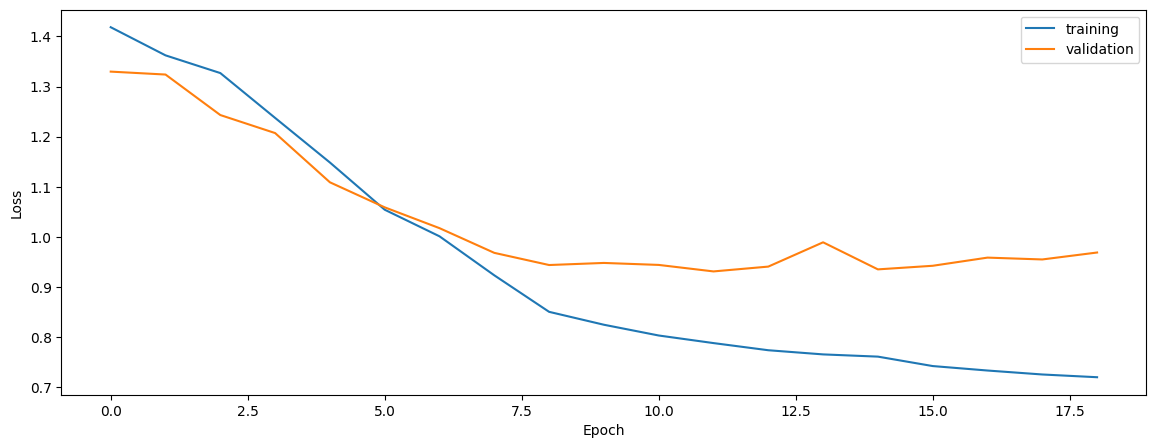

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6950040167176806
0.6496804163319478
0.5971665265938287


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6950040167176806
0.6496804163319478
0.5971665265938287


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6897876676857281
0.6540560888386975
0.5928701640672474


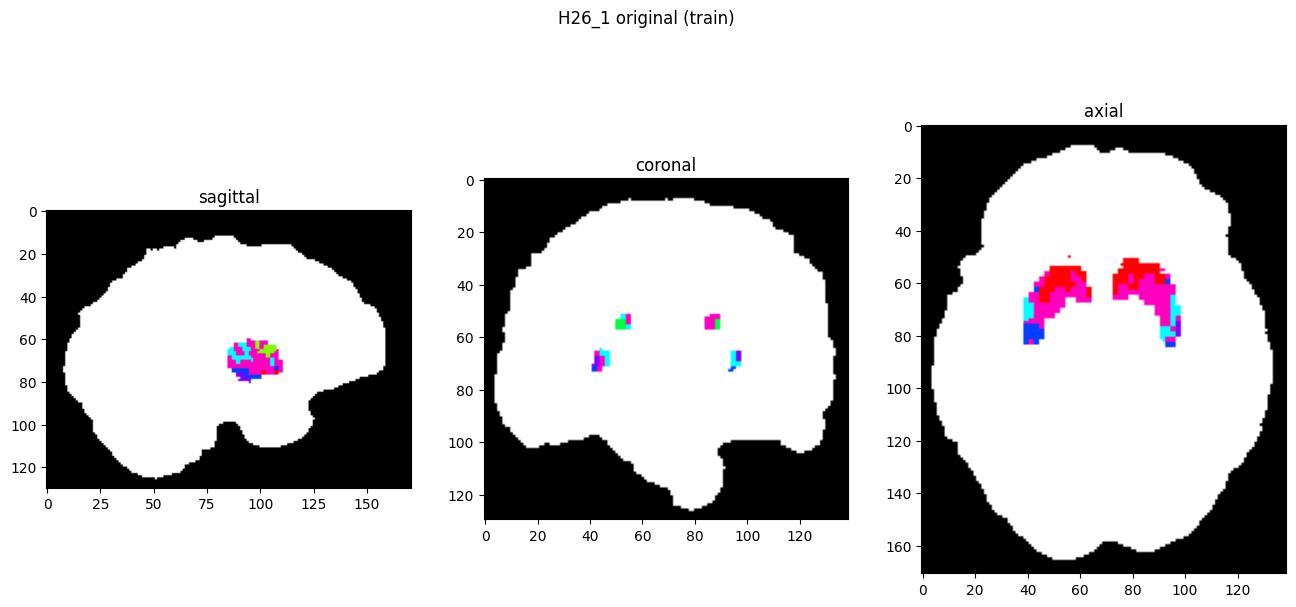

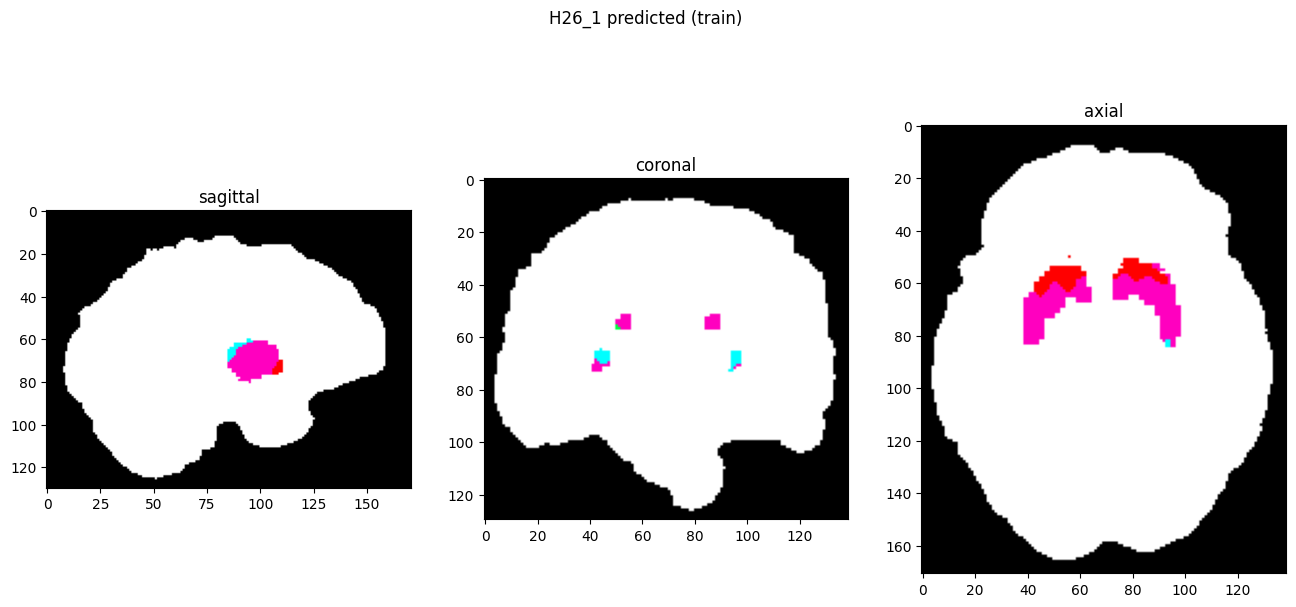

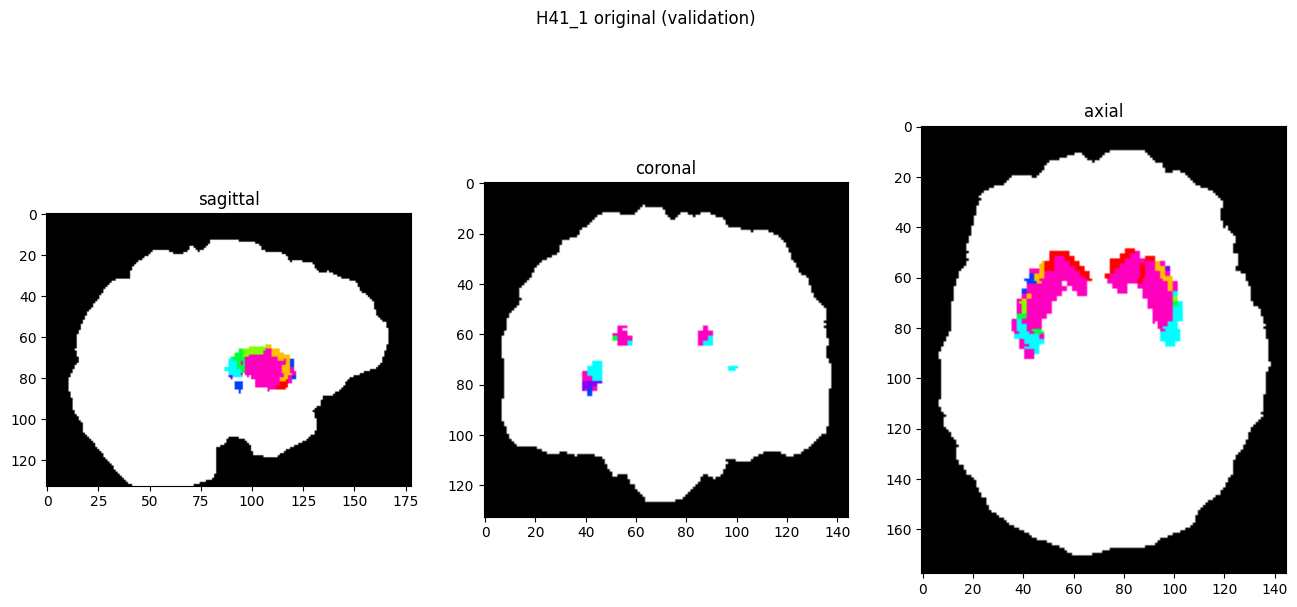

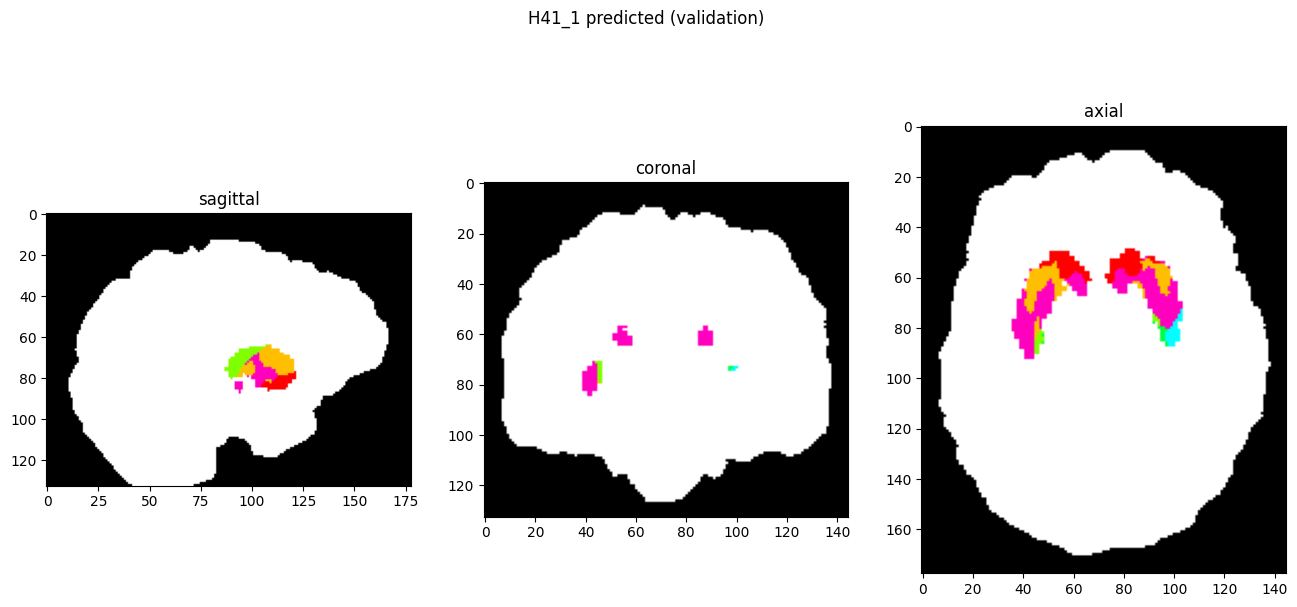

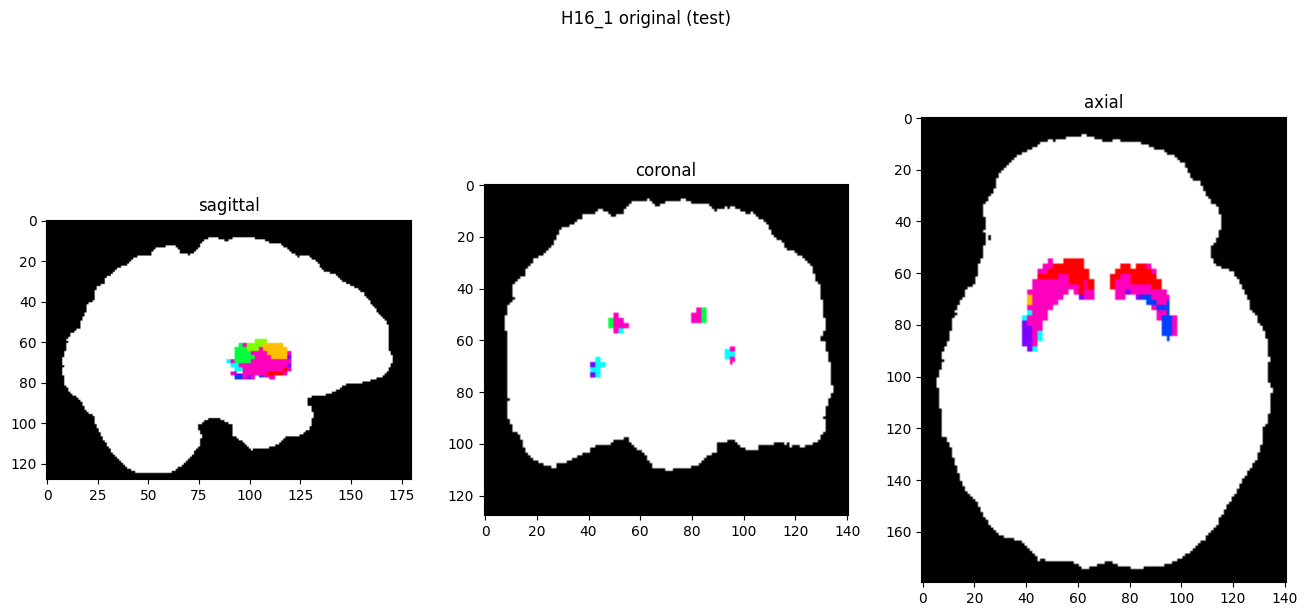

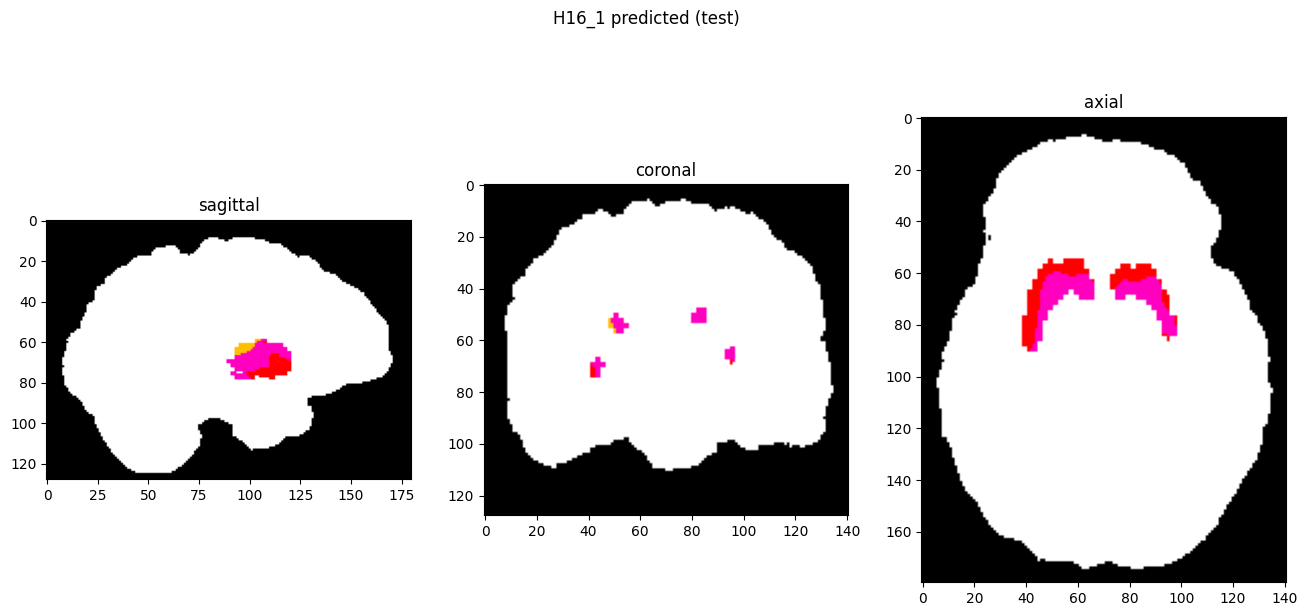

In [10]:
showResults(model, gen, threshold=0)